In [4]:
import numpy as np
import cv2 as cv
import math
from matplotlib import pyplot as plt
img_array = []
for i in range(0,360,5):
    img = cv.imread(r'C:\Users\Murali\Desktop\Mtech\Sem2\ComputerVision\paper\github\scene_change_detection\COIL\coil-100\coil-100\dog2.jpg')
    mask = np.zeros(img.shape[:2],np.uint8)#GC_BGD,GC_FGD,GC_PR_BGD,GC_PR_FGD 
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    rect = (0,40,470,300)
    cv.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img = img*mask2[:,:,np.newaxis]
    img_array.append(img)


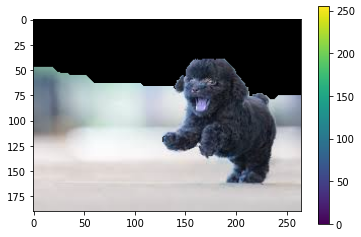

In [5]:
for img in img_array:
    plt.imshow(img),plt.colorbar(),plt.show()
    break

In [62]:
im1 = img_array[0]
im2 = img_array[1]

im1_gray = cv.cvtColor(im1,cv.COLOR_BGR2GRAY)
im2_gray = cv.cvtColor(im2,cv.COLOR_BGR2GRAY)

sz = im1.shape

# warp_mode = cv.MOTION_HOMOGRAPHY
warp_mode = cv.MOTION_EUCLIDEAN

if warp_mode == cv.MOTION_HOMOGRAPHY :
    warp_matrix = np.eye(3, 3, dtype=np.float32)
else:
    warp_matrix = np.eye(2, 3, dtype=np.float32)
    
number_of_iterations = 5000;

termination_eps = 1e-10;

criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

(cc, warp_matrix) = cv.findTransformECC (im1_gray,im2_gray,warp_matrix, warp_mode, criteria)
 
if warp_mode == cv.MOTION_HOMOGRAPHY :
    im2_aligned = cv.warpPerspective(im2, warp_matrix, (sz[1],sz[0]), flags=cv.INTER_LINEAR + cv.WARP_INVERSE_MAP)
else:
#     im2_aligned = cv.warpAffine(im2, warp_matrix, (sz[1],sz[0]))
    im2_aligned = cv.warpAffine(im2, warp_matrix, (sz[1],sz[0]), flags=cv.INTER_LINEAR + cv.WARP_INVERSE_MAP)

print("Correlation coefficient:",cc)    
    
# cv.imshow("Image 1", im1)
# cv.imshow("Image 2", im2)
# cv.imshow("Aligned Image 2", im2_aligned)
# cv.waitKey(0)
# print(im2_aligned)

Correlation coefficient: 0.9916134105566787


In [64]:
im1_gray = cv.cvtColor(im1,cv.COLOR_BGR2GRAY)
im2_aligned_gray = cv.cvtColor(im2_aligned,cv.COLOR_BGR2GRAY)

In [65]:
row = im1.shape[0]
col = im1.shape[1]

tiles1 = []
tiles2 = []
block_size = 32
for y in range(0, row, block_size):
    for x in range(0, col, block_size):
        tiles1.append(im1_gray[x:x+block_size,y:y+block_size])
        tiles2.append(im2_aligned_gray[x:x+block_size,y:y+block_size])

In [66]:
import pywt
dwt_img1 = []
dwt_aligned = []
for i in range(len(tiles1)):
    (cA,(cH,cV,cD)) = pywt.dwt2(tiles1[i], 'haar')
    dwt_img1.append([np.array(cA),np.array(cH),np.array(cV),np.array(cD)])
    (cA1,(cH1,cV1,cD1)) = pywt.dwt2(tiles2[i], 'haar')
    dwt_aligned.append([np.array(cA1),np.array(cH1),np.array(cV1),np.array(cD1)])
        
# print("Approximation coefficients:\n", cA)
# print("Horizontal detail coefficients:\n", cH)
# print("Vertical detail coefficients:\n", cV)
# print("Diagonal detail coefficients:\n", cD)

In [67]:
dwt_img1 = np.array(dwt_img1)
dwt_aligned = np.array(dwt_aligned)

In [68]:
def pcc(cAA,cHA,cVA,cDA,cAR,cHR,cVR,cDR):
#     numerator  = (4*(np.dot(cAA,cAR)+np.dot(cHA,cHR)+np.dot(cVA,cVR)+np.dot(cDA,cDR))) - np.dot((cAA+cHA+cVA+cDA),(cAR+cHR+cVR+cDR))
#     denominator =(4*(np.dot(cAA,cAA)+np.dot(cHA,cHA)+np.dot(cVA,cVA)+np.dot(cDA,cDA)))*(4*(np.dot((cAA+cHA+cVA+cDA),(cAA+cHA+cVA+cDA)))*(np.dot((cAR+cHR+cVR+cDR),(cAR+cHR+cVR+cDR))))
#     numerator = (4*((cAA*cAR)+(cHA*cHR)+(cVA*cVR)+(cDA*cDR)))-((cAA+cHA+cVA+cDA)*(cAR+cHR+cVR+cDR))
#     denominator = math.sqrt(abs(((4*((cAA*cAA)+(cHA*cHA)+(cVA*cVA)+(cDA*cDA)))-(cAA+cHA+cVA+cDA)**2)-((4*((cAR*cAR)+(cHR*cHR)+(cVR*cVR)+(cDR*cDR)))-(cAR+cHR+cVR+cDR)**2)))
#     r = (numerator/denominator)
#     print(denominator)
    pcc = np.corrcoef(np.concatenate((cAA.flatten(), cHA.flatten(), cVA.flatten(), cDA.flatten())),np.concatenate((cAR.flatten(), cHR.flatten(), cVR.flatten(), cDR.flatten())))[0, 1]
#     return pcc
    return pcc

In [58]:
# (dwt_img1[0].flatten() == dwt_img1[8].flatten()).sum()
# 4*16*16*16 = 16384

1024

In [69]:
def pcc_single(cA,cR):
    pcc = np.corrcoef(cA.flatten(),cR.flatten())[0,1]
    return pcc

In [70]:
pcc_result = []
for i in range(len(dwt_aligned)):
#     result = pcc(dwt_img1[i][0].mean(),dwt_img1[i][1].mean(),dwt_img1[i][2].mean(),dwt_img1[i][3].mean(),dwt_aligned[i][0].mean(),dwt_aligned[i][1].mean(),dwt_aligned[i][2].mean(),dwt_aligned[i][3].mean())
#     print(result)
#     print(dwt_aligned[i][0].mean())
#     resultA = pcc_single(dwt_img1[i][0],dwt_aligned[i][0])
#     resultH = pcc_single(dwt_img1[i][1],dwt_aligned[i][1])
#     resultV = pcc_single(dwt_img1[i][2],dwt_aligned[i][1])
#     resultD = pcc_single(dwt_img1[i][3],dwt_aligned[i][1])
#     result = (resultA+resultH+resultV+resultD)/4
    result = pcc(dwt_img1[i][0],dwt_img1[i][1],dwt_img1[i][2],dwt_img1[i][3],dwt_aligned[i][0],dwt_aligned[i][1],dwt_aligned[i][2],dwt_aligned[i][3])
    pcc_result.append(result)
    
print("This is the pcc result")
pcc_result = [1 if math.isnan(x) else x for x in pcc_result]
pcc_result

This is the pcc result


[1,
 0.811296650374123,
 0.9077495437054521,
 1,
 1,
 0.9368253364400715,
 0.9714101994756699,
 1,
 1,
 0.9515091583799375,
 0.9863821476802892,
 1,
 1,
 0.8514625318405318,
 0.9604083859201159,
 1]

In [46]:
theta = 0.80
change = np.array([0 if x > theta else 1 for x in pcc_result])
change

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [47]:
for i in range(0,len(change)):
    tiles1[i] = tiles1[i]*change[i]
    tiles2[i] = tiles2[i]*change[i]

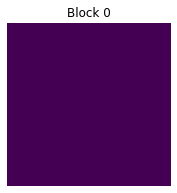

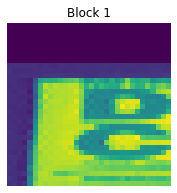

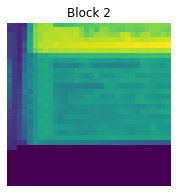

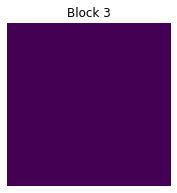

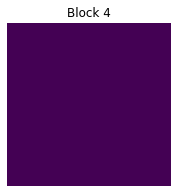

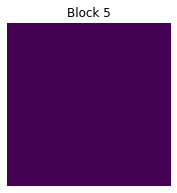

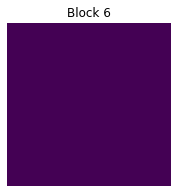

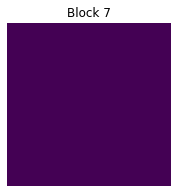

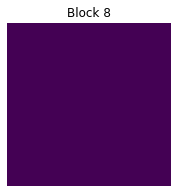

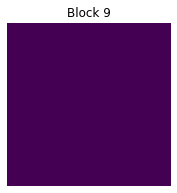

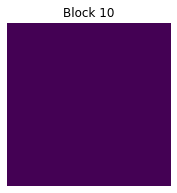

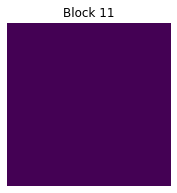

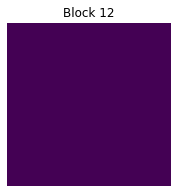

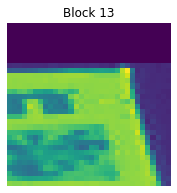

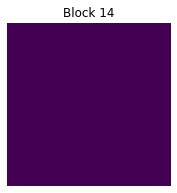

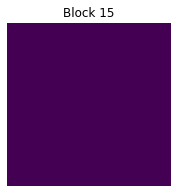

In [48]:
for i in range(0,len(tiles1)):
    fig = plt.figure(figsize=(12, 3))
    plt.imshow(tiles1[i])
    plt.title("Block "+str(i))
    plt.axis('off')